# Training vs validation loss

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/3.train-test-diabetes.ipynb)

By [Terence Parr](https://explained.ai).

This notebook explores how to use a validation set to estimate how well a model generalizes from its training data to unknown test vectors. We will see that deep learning models often have so many parameters that we can drive training loss to zero, but unfortunately the validation loss grows as the model overfits. We will also compare how deep learning does compared to a random forest model as a baseline.

## Support code

In [1]:
import os
import sys
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def plot_history(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")

In [3]:
d = load_diabetes()
len(d.data)

442

In [4]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [5]:
np.random.seed(1) # set a random seed for consistency across runs
n = len(df)
n_test = int(n*0.20) # 20% held out as validation set
n_train = n - n_test
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [6]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [7]:
rf = RandomForestRegressor(n_estimators=500)#, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 455.43 validation MSE 3405.60


In [8]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Train network with increasingly sophisticated train method

### Most basic network training; just track training loss

In [9]:
def train0(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()

In [10]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

train0(model, X_train, X_test, y_train, y_test,
       learning_rate=.1, nepochs=1000)

Epoch    0 MSE train loss    29847.943
Epoch  100 MSE train loss     2383.253
Epoch  200 MSE train loss     1916.879
Epoch  300 MSE train loss     1280.354
Epoch  400 MSE train loss      918.777
Epoch  500 MSE train loss      714.660
Epoch  600 MSE train loss      607.696
Epoch  700 MSE train loss      538.283
Epoch  800 MSE train loss      456.674
Epoch  900 MSE train loss      833.338
Epoch 1000 MSE train loss      396.944


### Track validation loss and compare with plot, demonstrate overfitting

In [11]:
def train1(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

Epoch    0 MSE train loss    29866.576   test loss    25946.508
Epoch  100 MSE train loss     2399.647   test loss     3080.484
Epoch  200 MSE train loss     1956.136   test loss     3296.121
Epoch  300 MSE train loss     1380.913   test loss     3727.843
Epoch  400 MSE train loss      995.144   test loss     4223.445
Epoch  500 MSE train loss      721.155   test loss     4511.159
Epoch  600 MSE train loss      581.235   test loss     4655.608
Epoch  700 MSE train loss      460.486   test loss     4690.784
Epoch  800 MSE train loss      374.013   test loss     4812.422
Epoch  900 MSE train loss      370.744   test loss     5050.194
Epoch 1000 MSE train loss      264.342   test loss     5307.039


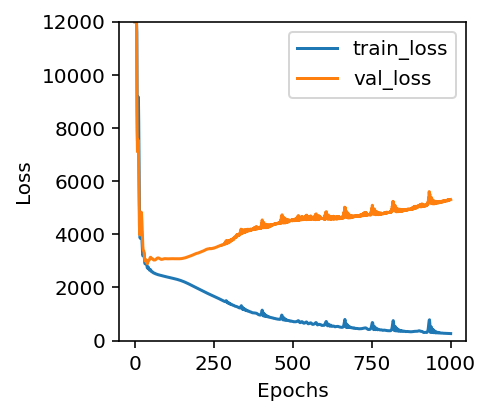

In [12]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history = train1(model, X_train, X_test, y_train, y_test,
                 learning_rate=.1, nepochs=1000)

plot_history(torch.clamp(history, 0, 12000), file="train-test")

### Use weight decay to reduce overfitting

In [13]:
def train2(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0, trace=True):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

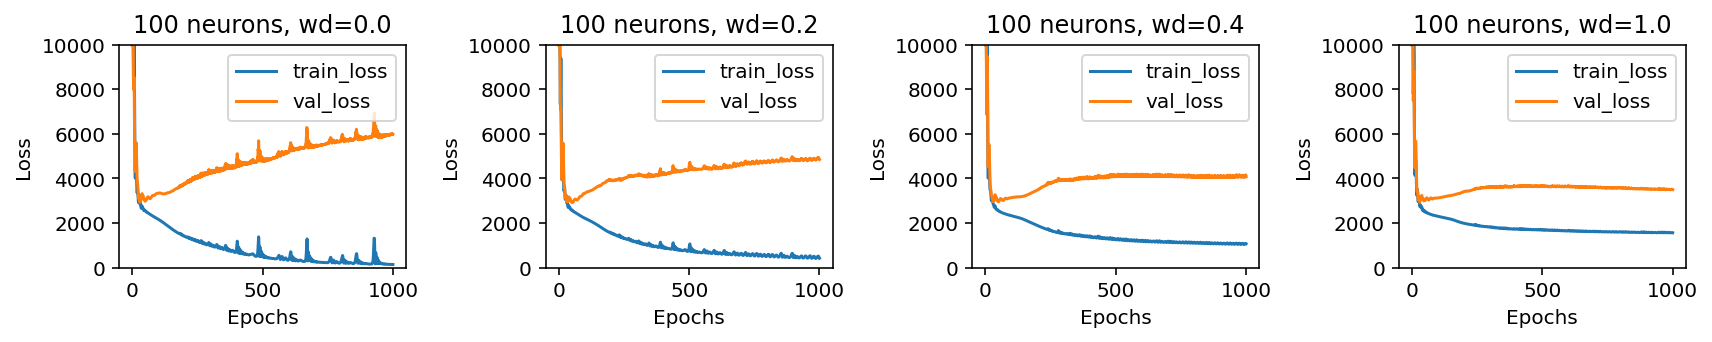

In [14]:
ncols = X.shape[1]
n_neurons = 100

fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

for wd,ax in zip([0,.2,.4,1],axes):
    model = nn.Sequential(
        nn.Linear(ncols, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, 1)
    )
    history = train2(model, X_train, X_test, y_train, y_test,
                     learning_rate=.15, nepochs=1000, weight_decay=wd,
                     trace=False)
    ax.set_title(f"{n_neurons} neurons, wd={wd:.1f}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()

### Track best loss, model; crank up neurons and stop early

In [15]:
def train3(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"BEST MSE test loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    29757.131   test loss    25870.844
Epoch  200 MSE train loss     9160.285   test loss     8456.637
Epoch  400 MSE train loss     4065.546   test loss     4293.648
Epoch  600 MSE train loss     3119.633   test loss     3472.252
Epoch  800 MSE train loss     2740.136   test loss     3177.496
Epoch 1000 MSE train loss     2580.942   test loss     3105.784
Epoch 1200 MSE train loss     2491.764   test loss     3088.142
Epoch 1400 MSE train loss     2433.232   test loss     3084.701
Epoch 1600 MSE train loss     2389.318   test loss     3094.432
Epoch 1800 MSE train loss     2355.364   test loss     3104.099
Epoch 2000 MSE train loss     2329.205   test loss     3115.781
BEST MSE test loss 3083.585 at epoch 1350
MSE test loss 3083.585


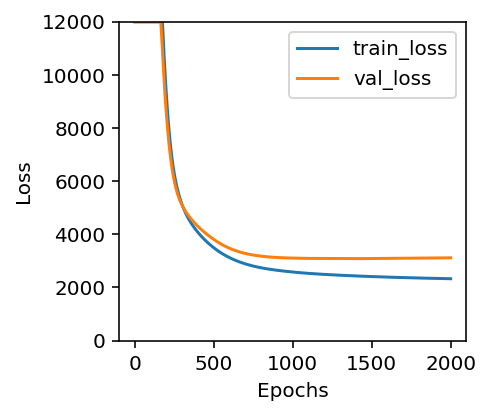

In [16]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train3(model, X_train, X_test, y_train, y_test,
                             learning_rate=.0015, nepochs=2000,
                             weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))